In [1]:
pwd

'/Users/mkbelay/Documents/PPOL 564/Data Science Project/PPOL-564-Data-Science-Project/Data Analysis'

In [2]:
##import packages to be used in this session
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.impute import SimpleImputer

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

This attempt will use the same data set as attempt 3. However, there will be modifications regarding variable selection; pre-processing; and the creation of the outcome variable. The last attempt showed that using more features along with a modified outcome variable tracking disparity for a single race reduced the mean squared error substantially. This final attempt will build on that information by creating five separate outcome variables and conducting five iterations of the modeling and interpretation process. Also, unlike the previous attempts, imputing will be used to address missingness. Additionally, the correlation between the features will be considered when selecting variables for the predictive model. 

One additional difference is that the scoring metric will be root mean squared error rather than mean squared error. As pointed out in the feedback I recieved in my presentation, the root mean squared error is easier to interpret. 

In [3]:
##import project csv file
df=pd.read_csv("COVID_project_PPOL564_v2.csv")

In [4]:
##print shape
df.shape

(974, 46)

In [5]:
##view first 10 observations
df.head(10)

,fips,state,county,cases,white_cases,black_cases,hispanic_cases,native_cases,asian_cases,TOT_POP,...,perc_plumb,lng_commute,life_exp,pre_mortality,phys_distress,ment_distress,diab_prevalence,food_insecure,food_access,perc_rural
0,1001,AL,Autauga County,119,44,21,0,0,0,55869,...,0.013462,0.396,76.879477,417.547551,0.136852,0.141293,0.111,0.132,0.119911,0.420022
1,1003,AL,Baldwin County,201,144,6,0,0,0,223234,...,0.004790,0.417,78.450258,353.343111,0.124801,0.134753,0.107,0.116,0.054244,0.422791
2,1005,AL,Barbour County,91,5,32,0,0,0,24686,...,0.006031,0.322,75.341935,497.350062,0.171849,0.165863,0.176,0.220,0.107397,0.677896
3,1007,AL,Bibb County,50,17,5,0,0,0,22394,...,0.007092,0.498,73.571820,589.041117,0.136266,0.140175,0.145,0.143,0.026016,0.683526
4,1009,AL,Blount County,37,15,0,0,0,0,57826,...,0.010912,0.594,74.145826,515.611823,0.145232,0.148593,0.170,0.107,0.028801,0.899515
5,1011,AL,Bullock County,125,0,106,0,0,0,10101,...,0.030942,0.460,73.530895,562.247530,0.168810,0.158548,0.237,0.248,0.197434,0.513744
6,1013,AL,Butler County,263,65,166,0,0,0,19448,...,0.003909,0.323,72.918309,609.169707,0.166967,0.169154,0.192,0.206,0.029261,0.712322
7,1015,AL,Calhoun County,124,72,23,0,0,0,113605,...,0.008431,0.312,73.039109,574.563842,0.147544,0.151915,0.175,0.157,0.091786,0.336968
8,1017,AL,Chambers County,301,81,181,0,0,0,33254,...,0.009386,0.318,74.291076,511.626517,0.152478,0.154967,0.199,0.179,0.103286,0.491480
9,1021,AL,Chilton County,65,27,0,0,0,0,44428,...,0.008123,0.503,74.926751,519.630806,0.145910,0.151771,0.186,0.131,0.014605,0.867447


We'll start by examining the data types and making adjustments to prepare for visualization and take notes for high-level pre-processing.

In [6]:
##check data types
df.dtypes

fips                   int64
state                 object
county                object
cases                  int64
white_cases            int64
black_cases            int64
hispanic_cases         int64
native_cases           int64
asian_cases            int64
TOT_POP                int64
WH                     int64
BA                     int64
AA                     int64
IA                     int64
HI                     int64
GDP                  float64
pov_perc             float64
Med_inc               object
Unemployment Rate    float64
traffic_vol          float64
house_burden         float64
ownership            float64
residential_seg      float64
food_index           float64
pop_to_phys          float64
water_violation      float64
air_pollution        float64
uninsured            float64
exercise_opp         float64
income_ineq          float64
crime_violent        float64
high_sch_grad        float64
some_college         float64
soc_association      float64
perc_high_cost

Let's convert 'Med_inc'(median household income) to a numeric data type as it is currently object/string data type. Let's also convert 'water_violation' to a categorical data type: this is a binary variable which takes on a value of either 0 or 1 to indicate if a water violation has been reported in the county. 

In [7]:
## remove commas from Med_inc column
df['Med_inc']=df['Med_inc'].str.replace(",","")
##change 'Med_inc' to dtype integer
df['Med_inc']=df['Med_inc'].astype('int')

In [8]:
## change 'water_violation' to dtype category
df['water_violation']=df['water_violation'].astype('category')

Now, we'll look at missingness in our data. This will determine if observations need to be removed; if imputation needs to be considered; or if observations need to be subsetted. 

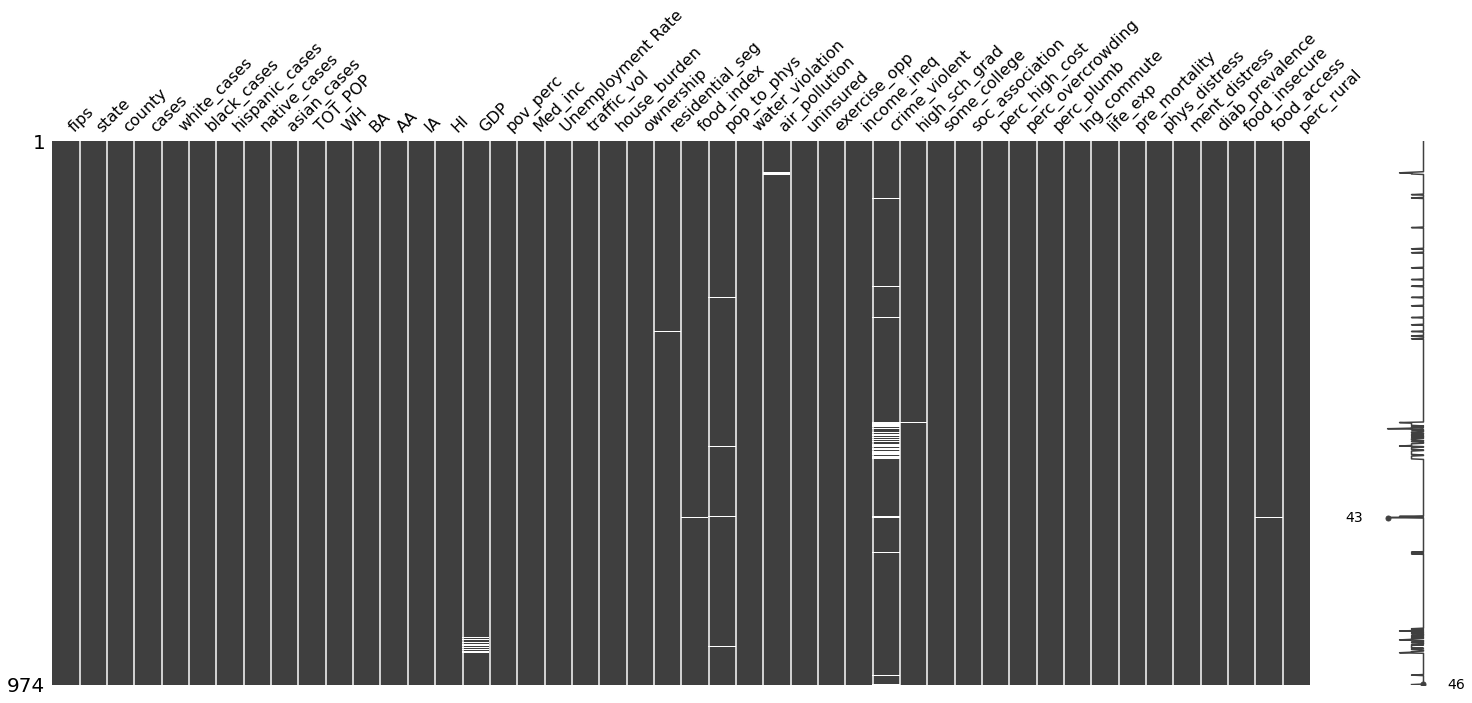

In [9]:
## examine missingness 
miss.matrix(df) 

Looking at the plot above, a couple of the feature variables stand out as having missing values: 'GDP' and 'crime_violent' seem to having the most missing observations, closely followed by 'residential_seg','food_index','pop_to_phys','water_violation', 'air_pollution', and 'food_access'. Next, a numeric description of missingness will be generated to see the extent of missingness and determine how best to deal with missing values. 

In [10]:
##numeric visualization of missingness 
df.isnull().sum()

fips                  0
state                 0
county                0
cases                 0
white_cases           0
black_cases           0
hispanic_cases        0
native_cases          0
asian_cases           0
TOT_POP               0
WH                    0
BA                    0
AA                    0
IA                    0
HI                    0
GDP                  19
pov_perc              0
Med_inc               0
Unemployment Rate     0
traffic_vol           0
house_burden          0
ownership             0
residential_seg       2
food_index            4
pop_to_phys           9
water_violation       1
air_pollution         4
uninsured             0
exercise_opp          0
income_ineq           0
crime_violent        56
high_sch_grad         1
some_college          0
soc_association       0
perc_high_cost        0
perc_overcrowding     0
perc_plumb            0
lng_commute           0
life_exp              0
pre_mortality         0
phys_distress         0
ment_distress   

The variable 'crime_violent' has the largest number of missing values. Instead of removing observations with missing values, pandas built-in functionality will be used to fill-in missing values based on information (mean) from the variable/column the missing values belong to. We will start by creating a modified dataframe because imputation using mean does not work on non-numeric data types. 

In [11]:
##create modified dataframe;keep fips in both dataframe to merge after imputation
df2_obj=df[['fips','state', 'county', 'water_violation']]
df2_int=df.drop(columns=['state', 'county', 'water_violation'])
## check shape
print (df2_obj.shape)
print (df2_int.shape)

(974, 4)
(974, 43)


In [12]:
## impute using mean for each column
df2_int=df2_int.apply(lambda x: x.fillna(x.mean()),axis=0)

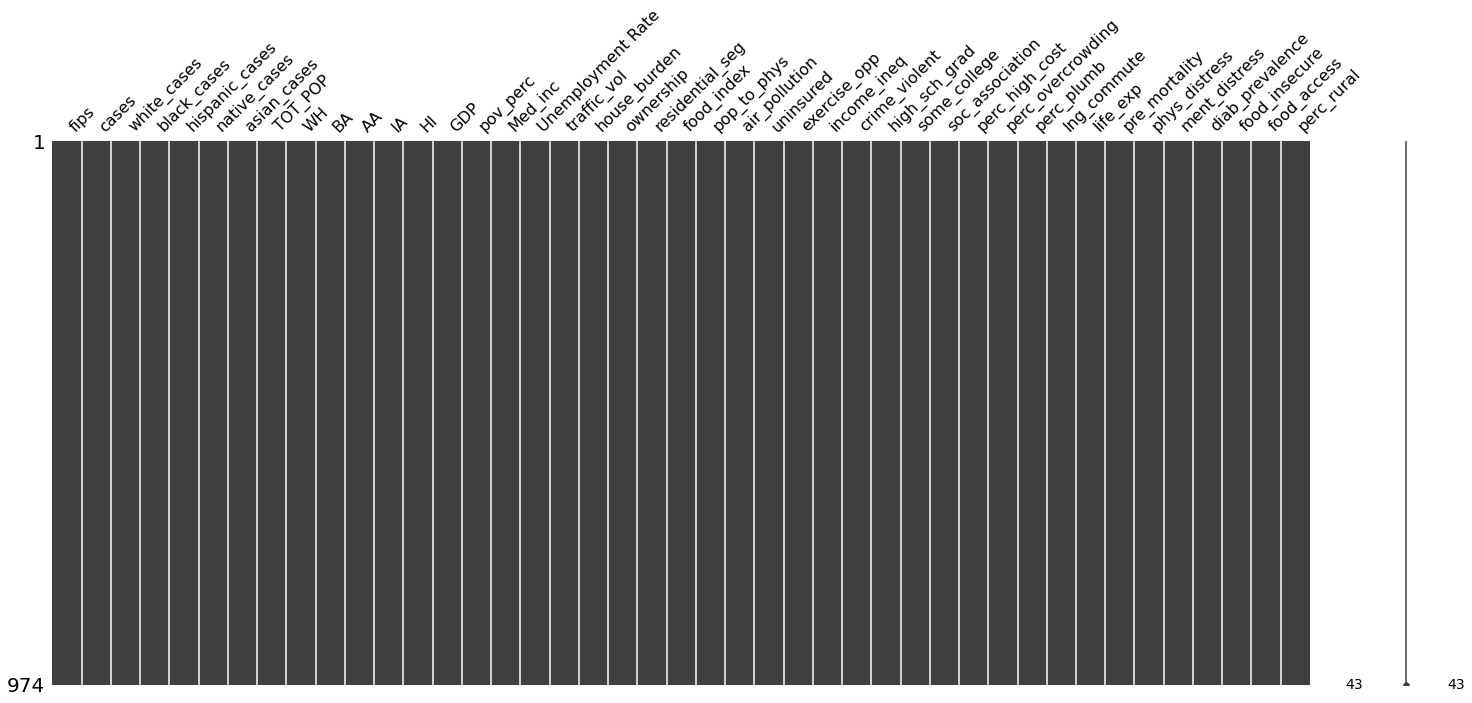

In [13]:
## check missingness to confirm imputation worked
miss.matrix(df2_int) 

In [14]:
## merge the separated dataframes into one
df2 = pd.merge(left=df2_obj, right=df2_int, how='left',on=["fips"], indicator=True)

In [15]:
##view left-only merges; 
df2.loc[df2._merge=="left_only",:]

,fips,state,county,water_violation,cases,white_cases,black_cases,hispanic_cases,native_cases,asian_cases,...,lng_commute,life_exp,pre_mortality,phys_distress,ment_distress,diab_prevalence,food_insecure,food_access,perc_rural,_merge


Merge is successful!

In [16]:
##drop _merge column
df2=df2.drop(columns= "_merge")

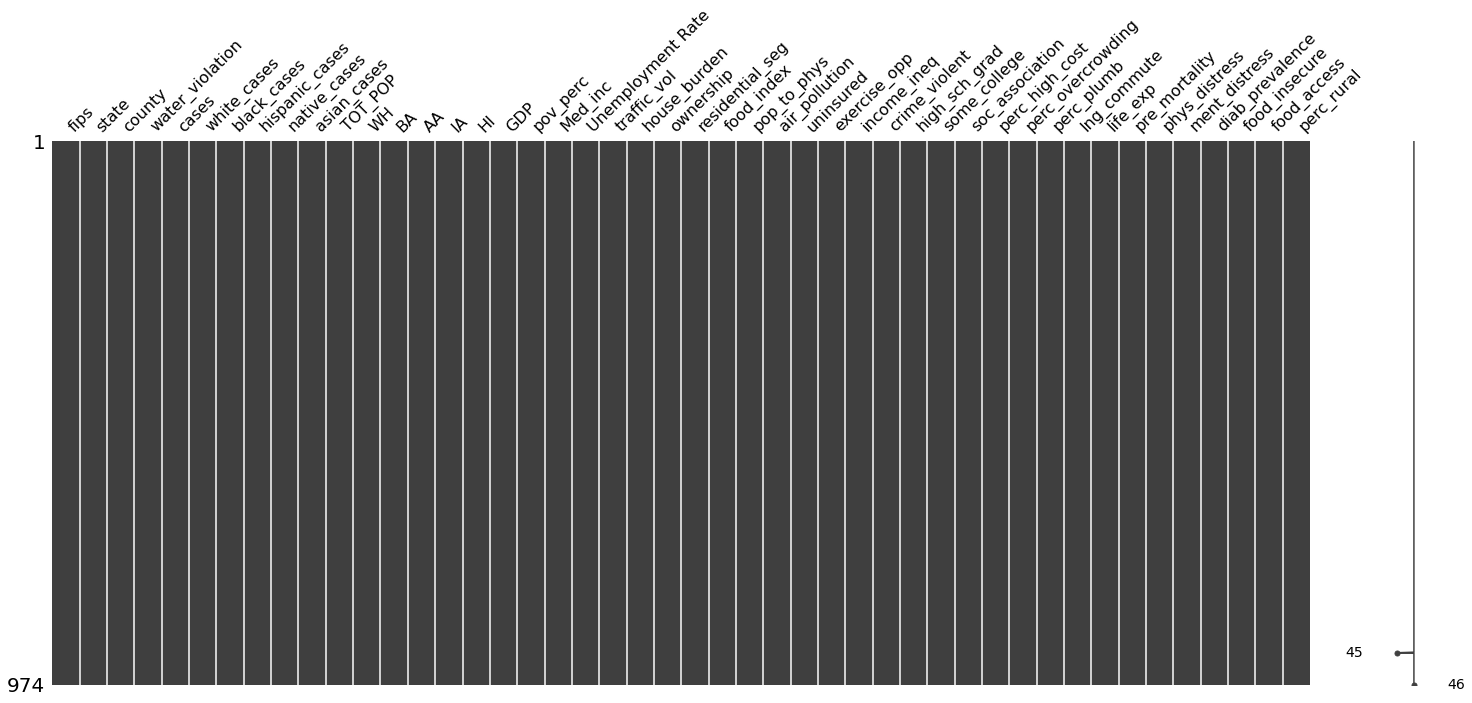

In [17]:
## check missingness of entire dataframe
miss.matrix(df2) 

There is one observation missing a value for water violation.Given that it is only one observation, it will be dropped.

In [18]:
## drop the only observation with an NA
df2=df2.dropna()

In [19]:
##check shape
df2.shape

(973, 46)

Before we begin exploring this data, we need to split it into a training and test dataset. Since the outcome variable has not been generated just yet, we will start by creating the outcome variable, then the data will be split into training and test.

### Step 1: Create Outcome Variable
The goal of this project is to examine the factors that lead to racial and ethnic health disparities among racial and ethnic minority population in COVID-19 cases. The outcome variable will be generated by: 
1. Calculating the COVID-19 percentage share by race and ethnicity for each county
2. Calculating the racial/ethnic distribution of populations for each county
3. Subtracting the COVID-19 case percentage from the population percentage for each race/ethnicity in each county. If the value is positive, it is indicative of a disparity in COVID-19 cases for that race/ethnicity; if the value is equal to 0, the COVID-19 cases for that race/ethnicity is the same as their population; lastly, if the value is negative, the COVID-19 cases for that race/ethnicity is less than their share of the population. This disparity metric calculation was taken from the CDC: https://www.cdc.gov/nchs/nvss/vsrr/covid19/health_disparities.htm. 

**NOTE: Unlike the first attempt, there will be five outcome variables which will measure disparity with in a county for each race/ethnicity for which a disparity has been found (Black, Hispanic, Native American. See also https://www.npr.org/sections/health-shots/2020/05/30/865413079/what-do-coronavirus-racial-disparities-look-like-state-by-state). This decision is motivated by the results from the previous model as well as literature on disparity research which notes that the influence of/experience with the county characteristics used in these models will vary for different racial/ethnic groups.**

#### 1. Calculating the COVID-19 percentage share by race and ethnicity for each county

##### Black Cases 

In [20]:
##calculate percentage share of black cases out of  total cases
df2['cases_bl_pop']=df2['black_cases']/df2['cases']

##### Native American Cases

In [21]:
df2['cases_na_pop']=df2['native_cases']/df2['cases']

##### Hispanic Cases

In [22]:
df2['cases_hi_pop']=df2['hispanic_cases']/df2['cases']

##### Asian American Cases

In [23]:
df2['cases_aa_pop']=df2['asian_cases']/df2['cases']

#### 2. Calculating the racial/ethnic distribution of populations for each county

##### Black Cases 

In [24]:
##calculate percentage of black population out of total population 
df2['bl_pop']=df2['BA']/df2['TOT_POP']

##### Native American Cases

In [25]:
##calculate percentage of natite american population out of total population 
df2['na_pop']=df2['IA']/df2['TOT_POP']

##### Hispanic Cases

In [26]:
##calculate percentage of hispanic population out of total population 
df2['hi_pop']=df2['HI']/df2['TOT_POP']

##### Asian American Cases

In [27]:
##calculate percentage of asian american population out of total population 
df2['aa_pop']=df2['AA']/df2['TOT_POP']

#### 3. Subtracting the COVID-19 case percentage from the population percentage for each race/ethnicity in each county.

##### Black Cases 

In [28]:
##create disparity index
df2['disp_index_BA']=df2['cases_bl_pop']-df2['bl_pop']
##multiply by 100
df2['disp_index_BA'] = df2['disp_index_BA'].apply(lambda x: x*10)

##### Native American Cases

In [29]:
##create disparity index
df2['disp_index_NA']=df2['cases_na_pop']-df2['na_pop']
##multiply by 100
df2['disp_index_NA'] = df2['disp_index_NA'].apply(lambda x: x*10)

##### Hispanic Cases

In [30]:
##create disparity index
df2['disp_index_HI']=df2['cases_hi_pop']-df2['hi_pop']
##multiply by 100
df2['disp_index_HI'] = df2['disp_index_HI'].apply(lambda x: x*10)

##### Asian American Cases

In [31]:
##create disparity index
df2['disp_index_AA']=df2['cases_aa_pop']-df2['aa_pop']
##multiply by 100
df2['disp_index_AA'] = df2['disp_index_AA'].apply(lambda x: x*10)

### Step 1.2: Examine correlations and select variables

In [32]:
## pearson correlation matrix
corr=df2.corr(method ='pearson') 

In [33]:
## isolate variable sets with a correlation greater than 0.7 or less than -0.7
corr_high=corr[((corr >= .7) | (corr <= -.7)) & (corr !=1.000000)]

In [34]:
## import seaborn to graph correlation
import seaborn as sn

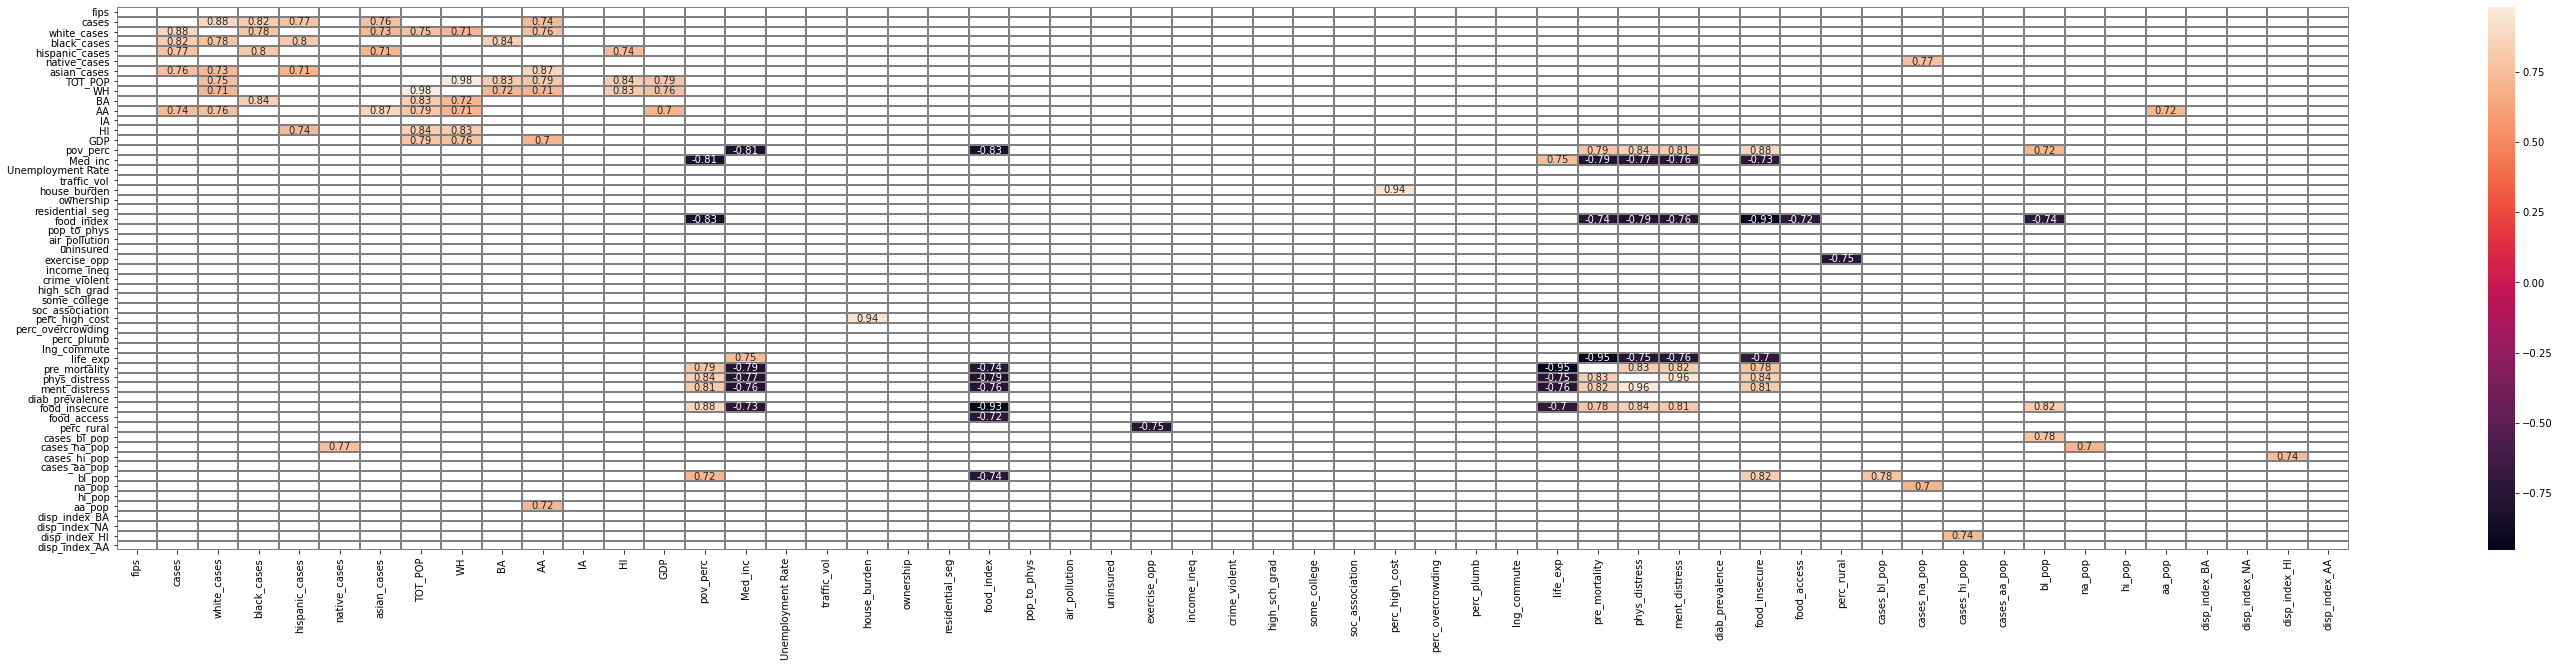

In [35]:
## plot correlation matrix 
plt.figure(figsize=(50,10))
sn.heatmap(corr_high, annot=True, linewidths=1, linecolor='grey',xticklabels=True, yticklabels=1)
plt.show()

Insights from matrix: 
1. Since the COVID-19 cases variables are correlated with one another and because they were used to create the outcome variables, these variables will be removed from all modeling approaches.
2. Total population is highly correlated with GDP. It will be dropped from all four modeling pipelines.
3. White population is highly corelated with GDP.This variable will be removed when running four separate modeling piplines for the four outcome variables. 
4. Asian american population is highly correlated with GDP. This variable will be removed when running four separate modeling piplines for the four outcome variables. 
5. Hispanic population will be removed only when using the disparity index which tracks disparity for hispanic population in county as an outcome variable. It is only highly correlated with the COVID-19 case variables which will be removed from all four modeling pipelines. 
6. Native American population will be removed only when using the disparity index which tracks disparity for native american population in county as an outcome variable. It is not highly correlated with any of the other features. 
7. Black population will be removed only when using the disparity index which tracks disparity for black population in county as an outcome variable. It is highly correlated with the COVID-19 cases variables which will be removed from all four modeling pipelines.   
5. Poverty rate is highly correlated with food insecruity , mental distress , physical distress , premature mortality, food index, and  median income.  
6. Median income is correlated with food insecure, mental distress, phsical distress, premature mortality, life expectany, and poverty rate. 

  - To remedy this (i.e., correlations identified in #5 and #6), median income will be dropped and poverty rate will be retained. 
  
        
7. Housing burden highly correlated with percentage of population with high housing costs (perc_high_cost). Housing burden will be removed.  
8. Food index highly correlated with poverty rate, premature mortality, physical distress, mental distress, food insecurity and food access. Food access will be retained in place of food index and food insecure. This is because food insecure and food index are highly correlated with other important variables (ex: life expectancy) as well. 

9. Exercise opportunity highly correlated with percent rural. Percent rural will be dropped.

10. Life expectancy highly correlated with median income , premature mortality, physical distress, mental distress, and food insecure. 
11. Premature mortality highly correlated with food index, pov percent; median income; life exp, physical distress, mental distress, and food insecure.
12. Physical distress is highly correlated with poverty, median income, food index,life expectancy, premature mortality, mental distress, and food insecure
13. Mental distress is highly corr with poverty, median income, food index, life expectancy, premature mortality, physical  distress, and food insecure.

  - To remedy this (i.e., correlations identified in #10 to #13), premature mortality; physical distress, and mental distress will be removed from all four modeling attempts. 

In [36]:
## remove variables identified above. 
df2=df2.drop(columns=['cases','black_cases','white_cases','native_cases','hispanic_cases', 'asian_cases',
                     'TOT_POP','WH', 'AA', 'Med_inc','house_burden','food_index', 'food_insecure', 'perc_rural',
                     'pre_mortality','phys_distress','ment_distress'])

### Step 2: Separate into training and test data sets

For now, we will isolate the four outcomes from the features and explore the features to identify high-level processing steps. Next, the high-level processing will be applied to the entire dataframe (df2) and the features and outcomes will be isolated again. Then, prior to the modeling process, a training and test split will be done. Note that the training and test split and the modeling process will be done four times for the four outcome variabels.


In [37]:
## isolate outcomes from features; disparity index for black population will be used as the main outcome for now
y = df2[['disp_index_BA']]
y_NA=df2[['disp_index_NA']]
y_HI=df2[['disp_index_HI']]
y_AA=df2[['disp_index_AA']]
X = df2.drop(columns=['disp_index_BA','disp_index_NA','disp_index_HI','disp_index_AA'])

In [38]:
## split in to training (75% of data) and test (25% of data); set random state to replicate same split every time
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [39]:
##check shape to confirm split
print(train_X.shape[0]/df2.shape[0])
print(test_X.shape[0]/df2.shape[0])

0.7492291880781089
0.25077081192189105


### Step 3: Explore training dataset

In [40]:
##view first 20 observations
train_X.head(20)

,fips,state,county,water_violation,BA,IA,HI,GDP,pov_perc,Unemployment Rate,...,diab_prevalence,food_access,cases_bl_pop,cases_na_pop,cases_hi_pop,cases_aa_pop,bl_pop,na_pop,hi_pop,aa_pop
804,42063,PA,Indiana County,1.0,2364,149,1146,4244361.0,15.5,5.0,...,0.107,0.090719,0.000000,0.000000,0.000000,0.000000,0.028118,0.001772,0.013631,0.010919
280,17153,IL,Pulaski County,0.0,1635,39,134,263742.0,19.7,6.6,...,0.196,0.095931,0.000000,0.000000,0.208333,0.000000,0.306467,0.007310,0.025117,0.004311
971,56021,WY,Laramie County,1.0,2510,1141,14843,5742537.0,9.1,3.5,...,0.094,0.104891,0.000000,0.000000,0.000000,0.000000,0.025226,0.011467,0.149176,0.013588
453,26157,MI,Tuscola County,0.0,695,359,1873,1423947.0,12.7,5.1,...,0.076,0.013405,0.029940,0.000000,0.000000,0.000000,0.013303,0.006871,0.035850,0.003484
525,28061,MS,Jasper County,0.0,8712,51,237,534860.0,19.0,6.8,...,0.223,0.061348,0.663934,0.000000,0.000000,0.000000,0.531771,0.003113,0.014466,0.001404
457,27003,MN,Anoka County,1.0,26336,3179,17370,15380653.0,5.6,3.1,...,0.089,0.064891,0.220679,0.000000,0.054012,0.034722,0.073787,0.008907,0.048666,0.049756
429,26073,MI,Isabella County,0.0,1864,2877,2889,2583490.0,23.4,3.8,...,0.080,0.036904,0.000000,0.000000,0.000000,0.000000,0.026677,0.041175,0.041347,0.018276
269,17109,IL,McDonough County,0.0,1630,119,874,1298699.0,21.9,4.7,...,0.094,0.067317,0.176471,0.000000,0.000000,0.000000,0.054915,0.004009,0.029445,0.024762
298,19017,IA,Bremer County,0.0,302,40,405,1151692.0,6.6,2.3,...,0.082,0.017076,0.000000,0.000000,0.000000,0.000000,0.012050,0.001596,0.016160,0.011531
249,17019,IL,Champaign County,1.0,29029,766,13117,11675933.0,19.2,3.8,...,0.093,0.044982,0.165010,0.000000,0.435388,0.000000,0.138438,0.003653,0.062555,0.109143


__What is the distribution of the feature variables?__

Check the distribution of all continious variables coded with dtype 'int'.

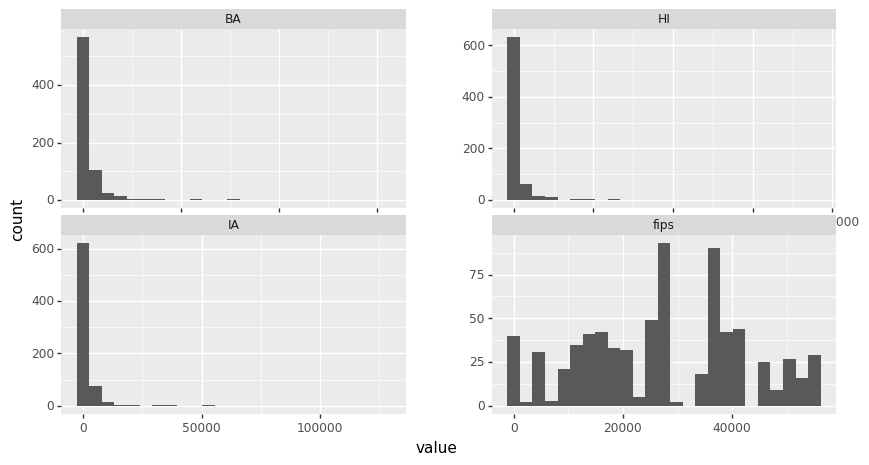

<ggplot: (8779370443894)>

In [41]:
## view continous int variables
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

The 'fips' variable will not be included in the model. The rest of the variables have a right skew. These variables represent a county's population by race/ethnicity. Let's log these variables and see how their distribution changes

In [42]:
## check if any of the variables have a value of 0 before taking their log
print((train_X == 0).sum())

fips                   0
state                  0
county                 0
water_violation      437
BA                     0
IA                     0
HI                     0
GDP                    0
pov_perc               0
Unemployment Rate      0
traffic_vol            0
ownership              0
residential_seg        0
pop_to_phys            0
air_pollution          0
uninsured              0
exercise_opp           1
income_ineq            0
crime_violent          0
high_sch_grad          0
some_college           0
soc_association        1
perc_high_cost         0
perc_overcrowding      0
perc_plumb             0
lng_commute            0
life_exp               0
diab_prevalence        0
food_access            1
cases_bl_pop         360
cases_na_pop         690
cases_hi_pop         454
cases_aa_pop         618
bl_pop                 0
na_pop                 0
hi_pop                 0
aa_pop                 0
dtype: int64


Variables to add 1 to when logging: exercise_opp, soc_association, and  food_access. Note that water violation is a categorical variable. It will be changed to a category dtypes in the high-level preprocessing stage. The other variables with zeros will not be included in the modeling process because they were generated to create the outcome variables.

In [43]:
## check min value to confirm absence of negative values before taking the log of any of the variables
print(train_X.min())

fips                        1001
state                         AK
county                Ada County
water_violation                0
BA                             9
IA                             9
HI                            63
GDP                       111976
pov_perc                     2.6
Unemployment Rate            1.6
traffic_vol              2.06772
ownership               0.196073
residential_seg          6.22173
pop_to_phys              440.142
air_pollution                3.9
uninsured               0.026826
exercise_opp                   0
income_ineq              3.07678
crime_violent            10.0083
high_sch_grad           0.525641
some_college            0.285632
soc_association                0
perc_high_cost         0.0491582
perc_overcrowding     0.00255319
perc_plumb           0.000407747
lng_commute                0.074
life_exp                 70.4621
diab_prevalence            0.019
food_access                    0
cases_bl_pop                   0
cases_na_p

In [44]:
##log variables
d = train_X.copy()
d['ln_BA'] =  np.log(d['BA'])
d['ln_IA'] =  np.log(d['IA'] )
d['ln_HI'] =  np.log(d['HI'])

In [45]:
##keep only logged variables
d=d.loc[:, d.columns.str.startswith('ln_')]
##transform from wide to long for visualization
d=d.melt()

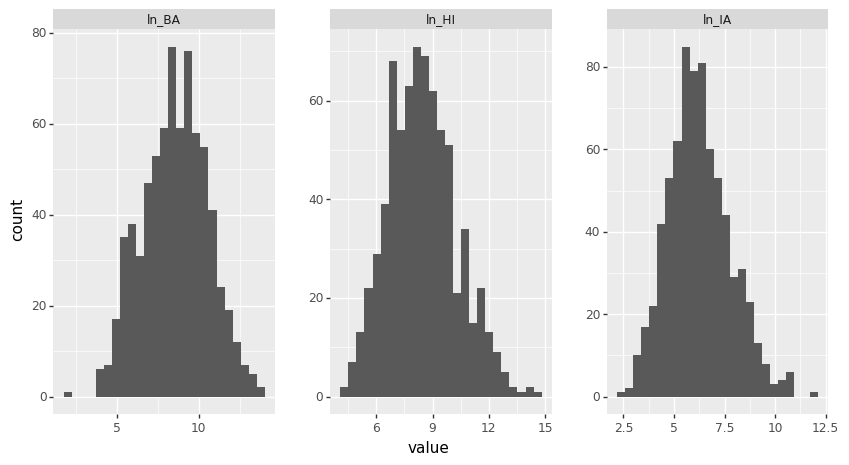

<ggplot: (8779370454504)>

In [46]:
##visualize
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

Logging seems to have normalized the distribution of the population variables. This will be applied to the entire dataframe in the high-level pre-processing stage.

Next, let us visualize the continious variables with dtype=float.

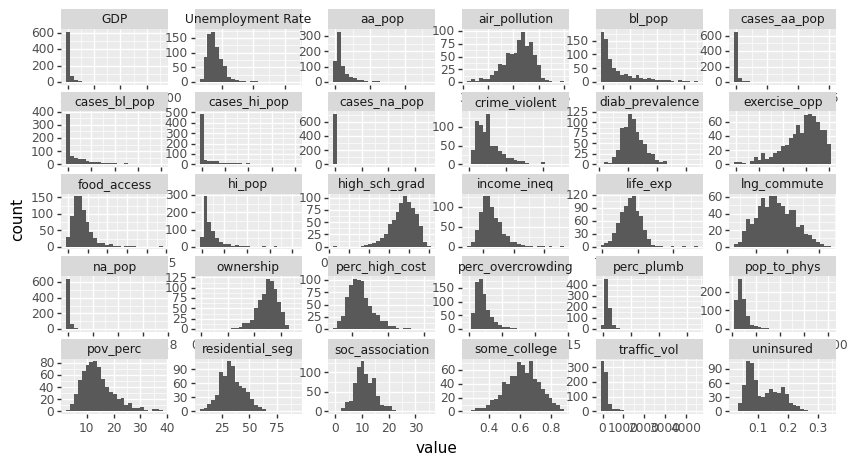

<ggplot: (8779370454366)>

In [47]:
## view continious float variables
e = train_X.select_dtypes(include="float").melt()
(
    ggplot(e,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

The variables that start with 'cases_' and the variables that end with '_ pop' will not be included in the modeling process because they were created to generate the outcome variables. GDP, Unemployment Rate, ownership, pop_to_phys, crime_violent, perc_plumb, perc_overcrowding, and traffic volume seem to have a pronounced skew. Let us log these variables and see how they look: 
    

In [48]:
##log variables
d = train_X.copy()
d['ln_GDP'] =  np.log(d['GDP'] )
d['ln_Unemployment Rate'] =  np.log(d['Unemployment Rate'] )
d['ln_ownership'] =  np.log(d['ownership'] )
d['ln_pop_to_phys'] =  np.log(d['pop_to_phys'] )
d['ln_traffic_vol'] =  np.log(d['traffic_vol'] )
d['ln_perc_plumb'] =  np.log(d['perc_plumb'] )
d['ln_perc_overcrowding'] =  np.log(d['perc_overcrowding'] )
d['ln_crime_violent'] =  np.log(d['crime_violent'] )

In [49]:
##keep only logged variables
d=d.loc[:, d.columns.str.startswith('ln_')]
##transform from wide to long for visualization
d=d.melt()

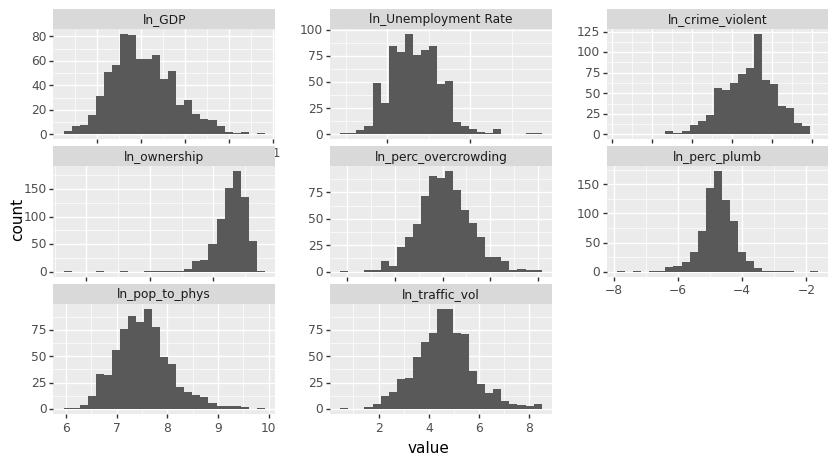

<ggplot: (8779342057638)>

In [50]:
##visualize
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

Logging seems to have normalized most of the variables, however, the variables 'ownership' has not benefitted from logging. It will be turned into categorical varaibles in the high-level preprocessing stage. 

Now let us look at the distribution of the only categorical variable. Based on the data source, "1 means “Yes” and indicates that at least one community water system in the county received at least one health-based violation during the specified time frame. 0 means “No” and indicates that there were no health-based drinking water violations in any community drinking water system in the county."https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-factors/physical-environment/air-water-quality/drinking-water-violations



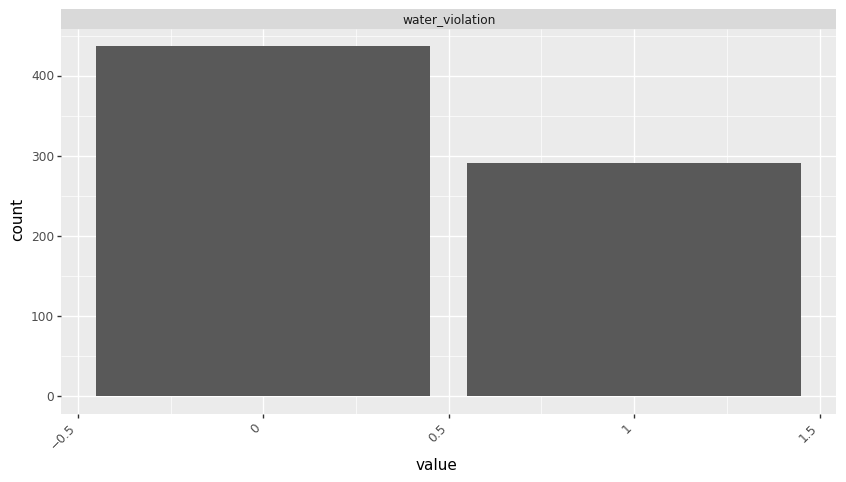

<ggplot: (8779341277022)>

In [51]:
##categorical variables
f = train_X.select_dtypes(include="category").melt()
(
    ggplot(f,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

Majority of the counties in the training data set have not recieved a health-based drinking water violation in 2018. Conversely, over 200 counties have recieved a  health-based drinking water violation in 2018.

__What is the distribution of the outcome variable?__

Let's look at how each disparity index is distributed for the black population. We will look at the other outcome variables right before we begin modeling for each of them. 

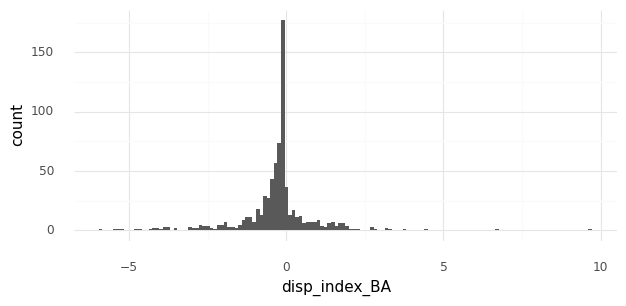

<ggplot: (8779342051229)>

In [52]:
##distribution of outcome variable (disp_index_BA) 
(
    ggplot(train_y,
           aes(x="disp_index_BA")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

Similar to attempt 1, it appears that, for majority of the counties represented in the training data set, the disparity index has a value less than zero. There are fewer observations the are greater than 0 on the disparity index (i.e, where disparity is detected). However, those few observations indicate quite a high disparity (see x-axis at around 10).

### Step 4:  High-level preprocessing

Similar to attempt 3,  I will log and bin variables based on the insights from the exploration of the training data above.

#### `BA`: Black  Population

In [53]:
df2['BA'] =  np.log(df2['BA'])

#### `IA`: Native American Population

In [54]:
df2['IA'] =  np.log(df2['IA'])

#### `HI`: Hispanic  Population

In [55]:
df2['HI'] =  np.log(df2['HI'])

#### `GDP`: County-Level GDP

In [56]:
df2['GDP'] =  np.log(df2['GDP'] )

#### `Unemployment Rate`: County-Level Unemployment Rate

In [57]:
df2['Unemployment Rate'] =  np.log(df2['Unemployment Rate'])

#### `ownership`: County-Level Homeownership

In [58]:
median_ownership = df2.loc[df2['ownership'] > 0,'ownership'].median()
df2['ownership'] =  np.where(df2['ownership']==0,0,np.where(df2['ownership'] <= median_ownership,1,2))

#### `pop_to_phys`: County-Level Ration of Physician to Population

In [59]:
df2['pop_to_phys'] =  np.log(df2['pop_to_phys'])

#### `perc_overcrowding`: Percentage of households with overcrowding

In [60]:
df2['perc_overcrowding'] =  np.log(df2['perc_overcrowding'])

#### `perc_plumbing`: Percentage of households with lack of kitchen or plumbing facilities

In [61]:
df2['perc_plumb'] =  np.log(df2['perc_plumb'])

#### `traffic_vol`: County-Level Traffic Volume

In [62]:
df2['traffic_vol'] =  np.log(df2['traffic_vol'])

#### `crime_violent`: County-Level Violent Crime Rate

In [63]:
df2['crime_violent'] =  np.log(df2['crime_violent'])

### Step 5: Resplit data

**Outcome Variable `disp_index_BA`: Diparity index tracking COVID-19 case disparity in Black Population**

Now let's resplit the pre-processed data frame and attempt the modeling process of the outcome variable 'disp_index_BA'--index tracking disparity amongst the Black population in a county.

In [64]:
##isolate outcome and features
y = df2[['disp_index_BA']]
##drop irrelevant columns when isolating features from outcome (including other outcome variables)
X = df2.drop(columns=['disp_index_BA','fips','state','county','cases_bl_pop', 'cases_na_pop',
       'cases_hi_pop', 'cases_aa_pop', 'bl_pop', 'na_pop', 'hi_pop', 'aa_pop',
                     'disp_index_BA','disp_index_NA','disp_index_HI','disp_index_AA'])
## also remove black population column because it was used to create the outcome variable
X=X.drop(columns=['BA'])

In [65]:
## split in to training (75% of data) and test (25% of data); set random state to replicate same split every time
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [66]:
##check shape to confirm split
print(train_X.shape[0]/df2.shape[0])
print(test_X.shape[0]/df2.shape[0])

0.7492291880781089
0.25077081192189105


### Step 6:  Pre-Processing

Let's rescale our training data for now, but we'll put the preprocessing into a modeling pipeline later on.

In [67]:
## scale so variables are on the same scale
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [68]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,water_violation,IA,HI,GDP,pov_perc,Unemployment Rate,traffic_vol,ownership,residential_seg,pop_to_phys,...,high_sch_grad,some_college,soc_association,perc_high_cost,perc_overcrowding,perc_plumb,lng_commute,life_exp,diab_prevalence,food_access
0,1.0,0.293751,0.281449,0.415079,0.368571,0.489600,0.535046,0.0,0.473474,0.370712,...,0.866136,0.491930,0.461680,0.334553,0.448270,0.699529,0.370995,0.277770,0.273292,0.191425
1,0.0,0.153467,0.073222,0.097823,0.488571,0.608894,0.181632,1.0,0.270165,0.437828,...,0.905910,0.483474,0.675570,0.219965,0.305564,0.625561,0.622260,0.220759,0.549689,0.202423
2,1.0,0.506808,0.529944,0.449599,0.185714,0.336341,0.633521,0.0,0.176668,0.308317,...,0.582123,0.696412,0.372681,0.179971,0.384751,0.432532,0.003373,0.323014,0.232919,0.221329
3,0.0,0.385786,0.329112,0.290368,0.288571,0.498109,0.259540,1.0,0.290183,0.512600,...,0.703772,0.449728,0.358101,0.270971,0.489922,0.442468,0.576728,0.269320,0.177019,0.028286
4,0.0,0.181543,0.128546,0.178558,0.468571,0.621722,0.158887,1.0,0.287885,0.664046,...,0.651017,0.379894,0.293502,0.261529,0.566957,0.657974,0.689713,0.183693,0.633540,0.129449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,1.0,0.631561,0.628520,0.523522,0.360000,0.174223,0.580320,0.0,0.317080,0.271949,...,0.740250,0.573974,0.243100,0.273840,0.671138,0.564946,0.325464,0.296157,0.217391,0.127882
725,0.0,0.072545,0.115415,0.162360,0.257143,0.284194,0.735788,1.0,0.575570,0.392135,...,0.978976,0.515004,0.291942,0.162940,0.551379,0.446569,0.365936,0.213910,0.332298,0.178710
726,0.0,0.372434,0.355876,0.374810,0.397143,0.382839,0.616528,0.0,0.201460,0.373170,...,0.911022,0.701145,0.276162,0.377166,0.297860,0.524994,0.456998,0.223345,0.260870,0.228526
727,1.0,0.297205,0.255493,0.414398,0.448571,0.545901,0.535448,0.0,0.322639,0.238086,...,0.872051,0.637511,0.459451,0.257014,0.346351,0.385131,0.295110,0.142446,0.416149,0.199767


### Step 6: Modeling

We have a continuously distributed outcome variable i.e., a regression problem.Let's test how these models perform

- Linear Regression 
- KNN
- Decision Trees
- Bagging 
- Random Forest

In [69]:
## set fold generator to split and test on same data across models
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

Let's run each model individually then compare the performance of the different models in a plot.

We'll use **root mean squared error** as our performance metrics.

In [70]:
## performance metric
use_metrics = ["neg_root_mean_squared_error"]

#### Linear Model

In [71]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### KNN

In [72]:
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Decision Tree

In [73]:
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

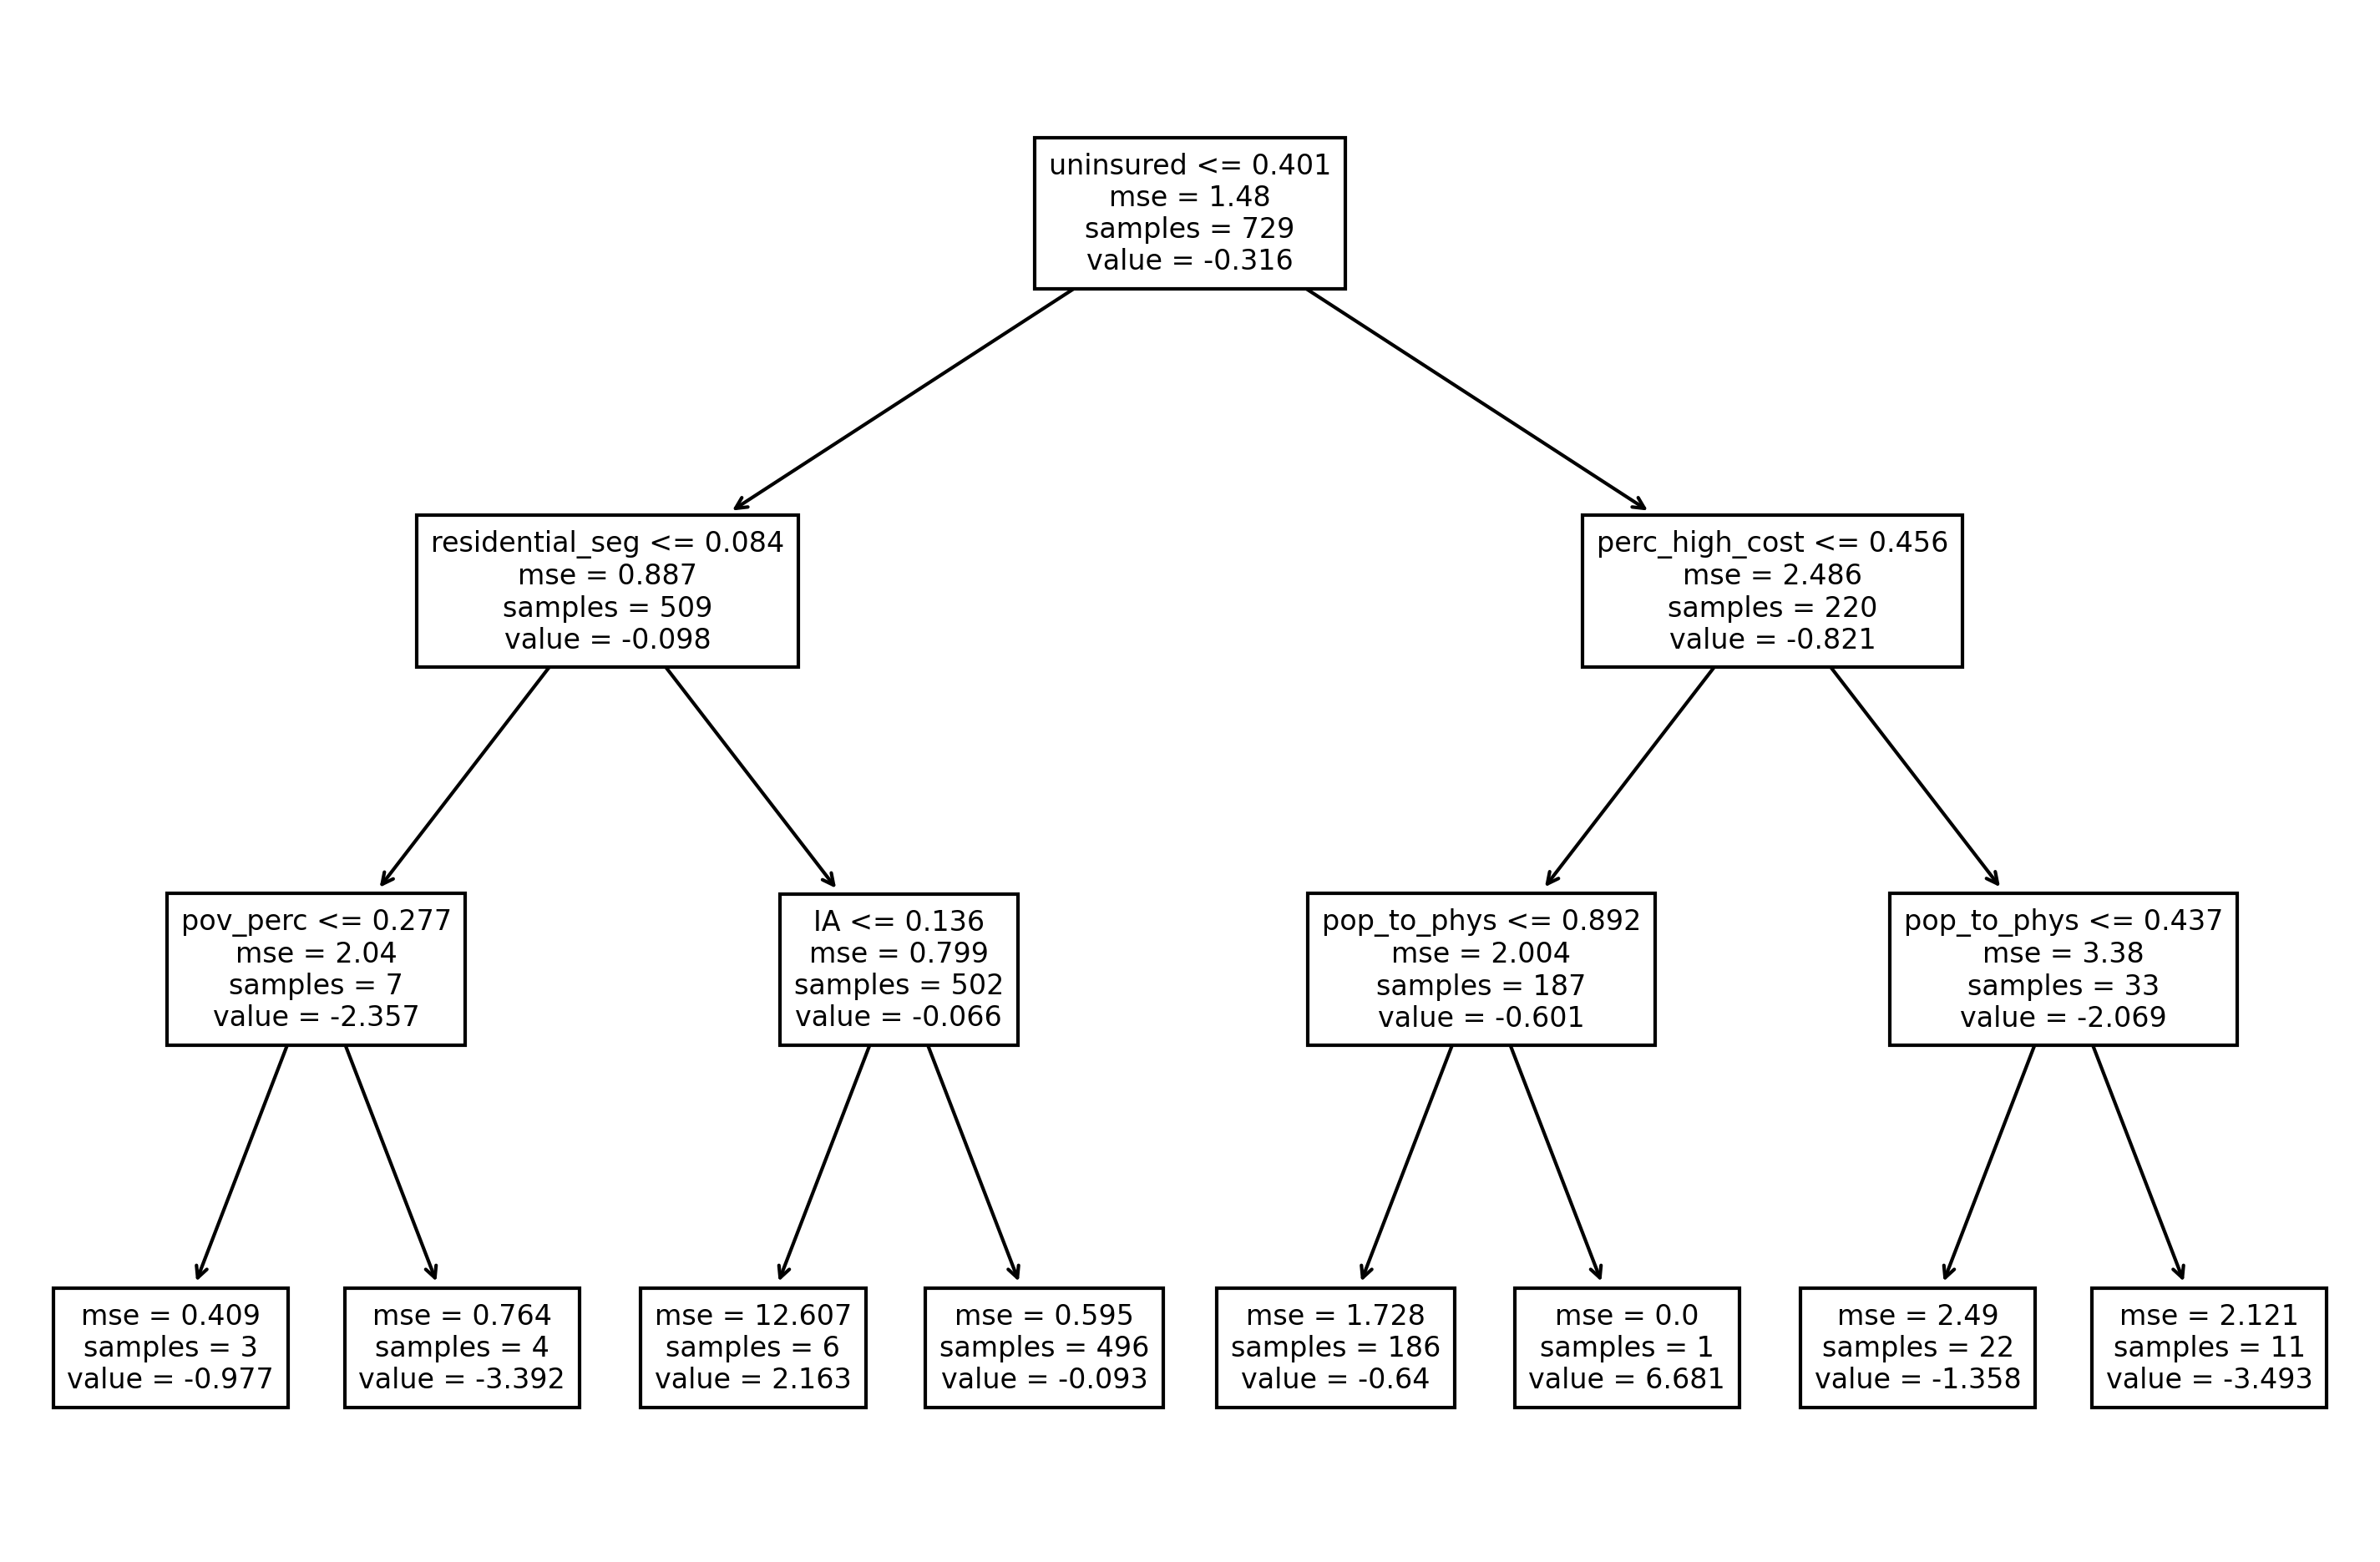

In [74]:
## let's visualize the decision tree's decisions to get some insights
mod = DTree(max_depth=3) # Initialize the modeling object 
mod.fit(train_X,train_y) # Fit the model

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

With  modifications to the preprocessing steps, the root mean squared errors are not as still low. While the tree still picked number of uninsured adults as its first variable (note that this occured across all attempts), we also see some new variables being selected: resedential segregation; percent of population with high housing costs; income inequality; and physician to population ratio.

#### Bagging

In [75]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

#### Random Forest

In [76]:
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

Let's collect the scores from each model and compare their performance. 

In [77]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_root_mean_squared_error']*-1,
     knn = knn_scores['test_neg_root_mean_squared_error']*-1,
     dt = dt_scores['test_neg_root_mean_squared_error']*-1,
     bag = bag_scores['test_neg_root_mean_squared_error']*-1,
     rf = rf_scores['test_neg_root_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores)
collect_scores

,lm,knn,dt,bag,rf
0,1.231453,1.347707,1.813706,1.298241,1.291256
1,0.953424,0.941801,1.292916,0.999952,0.906520
2,1.114775,1.083411,1.862210,1.273777,1.171100
3,1.209417,1.248301,2.009623,1.223173,1.191948
4,1.305927,1.259187,1.571300,1.319633,1.311649


In [78]:
##rename models
collect_scores=collect_scores.rename(columns={'lm':'Linear Model', 'knn':'KNN', 'dt':'Decision Tree', 'bag':'Bagging','rf':'Random Forest'})

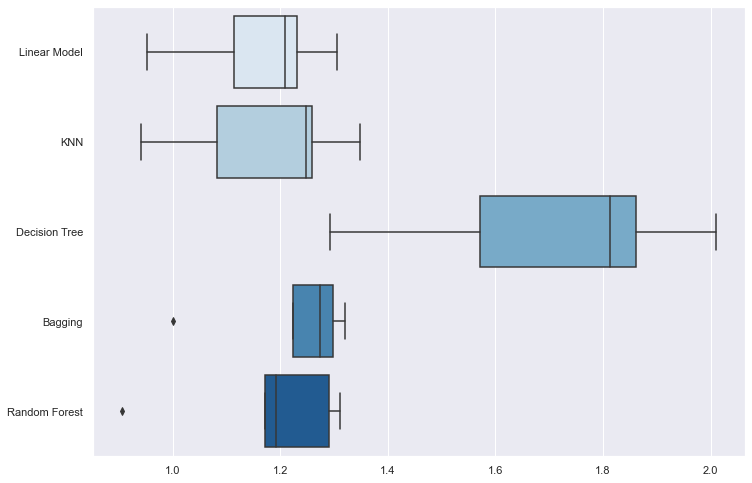

In [79]:
## let's visualize using seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=collect_scores, orient="h", palette="Blues")

Let's use ggplot for visualization, too.

In [80]:
##turn from wide to long for visualization
collect_scores=collect_scores.melt(var_name="Model",value_name="Root MSE")

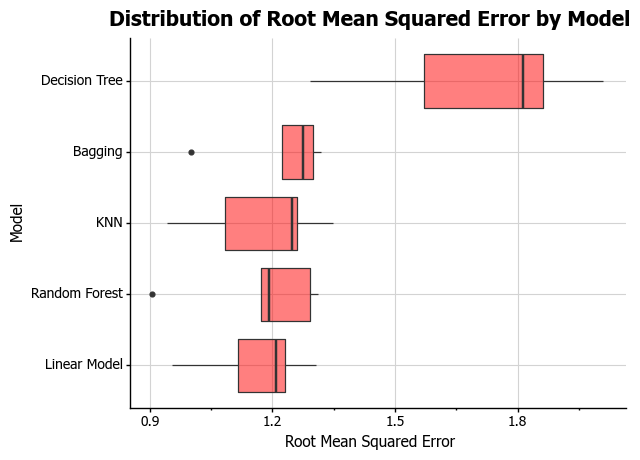

<ggplot: (8779342213039)>

In [81]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="Root MSE").index.tolist())

# Plot
MSE_model_4=(
    ggplot(collect_scores,
          aes(x="Model",y="Root MSE")) +
    geom_boxplot(fill="red", alpha=0.5) +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Root Mean Squared Error") +
    ##scale_color_brewer(palette="Blues") +
    coord_flip() + theme_classic()+ ggtitle("Distribution of Root Mean Squared Error by Model")
    + theme(dpi=100,
        legend_position="bottom",
        legend_direction="horizontal",
        legend_title_align="center",
        legend_box_spacing=0.4,
        legend_key=element_blank(),
        axis_line=element_line(size=1, colour="black"),
        panel_grid_major=element_line(colour="#d3d3d3"),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
        plot_title=element_text(size=15, family="Tahoma", 
                                face="bold"),
        text=element_text(family="Tahoma", size=11),
        axis_text_x=element_text(colour="black", size=10),
        axis_text_y=element_text(colour="black", size=10),
    )

)
MSE_model_4
##MSE_model_3.save("MSE_model_3.png")

Given that root mean squared error is easier to interpret (incorporating feedback from presentation)the mean squared errors fall in the range of a little less than 1 to over 1.8. The Linear Model and KNN beat out the Random Forest here, but note that the average as represented by the black line in each box is smaller in the Random Forest than in the Linear model or KNN. We also see that the minimum root MSE for bagging is actually lower than the Random Forest. Decision Tree continues to trail behind. 

### Tuning: KNN, Decision Tree, and Random Forest 

#### KNN

In [82]:
## try different number of neighbours to see which does best
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [83]:
## wrap tuning parameter in GridSearchCV
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4)

In [84]:
## fit model
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_root_mean_squared_error')

In [85]:
## see best parameter: how many neighbours?
tune_knn.best_params_

{'n_neighbors': 10}

In [86]:
## what is the best score?
tune_knn.best_score_

-1.1718930896026905

#### Decision Tree 

In [87]:
## try different number for the 'max_depth' parameter
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(20)]},
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4)

In [88]:
## fit model
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19]},
             scoring='neg_root_mean_squared_error')

In [89]:
## best parameter
tune_dt.best_params_

{'max_depth': 1}

In [90]:
## what is the best score
tune_dt.best_score_

-1.2377210705754227

#### Random Forest

In [91]:
## try different number for the 'max_depth','n_estimators', and 'max_features' parameters
rf_params = {'max_depth':[5, 10, 20],
             'n_estimators':[100,500,1000],
              'max_features': [10,20,30]}  

In [92]:
## wrap parameters in GridSearchCV
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=4)

In [93]:
## fit the model
tune_rf.fit(train_X,train_y) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 20], 'max_features': [10, 20, 30],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_root_mean_squared_error')

In [94]:
## best parameters
tune_rf.best_params_

{'max_depth': 20, 'max_features': 10, 'n_estimators': 1000}

In [95]:
## best score
tune_rf.best_score_

-1.156900648892638

After trying different configurations for the parameters, the Random Forest performed the best followed closely by KNN. The insights from tuning (i.e,. how to configure parameters) will be incorporated in the modeling pipeline below.

### Modeling Pipeline

In [96]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['water_violation', 'IA', 'HI', 'GDP', 'pov_perc', 'Unemployment Rate',
       'traffic_vol', 'ownership', 'residential_seg', 'pop_to_phys',
       'air_pollution', 'uninsured', 'exercise_opp', 'income_ineq',
       'crime_violent', 'high_sch_grad', 'some_college', 'soc_association',
       'perc_high_cost', 'perc_overcrowding', 'perc_plumb', 'lng_commute',
       'life_exp', 'diab_prevalence', 'food_access'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[i for i in range(20)]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[5, 10, 20],
     'model__n_estimators':[100,500,1000],
     'model__max_features': [10,20,30]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['water_violation',
                                                                          'IA',
                                                                          'HI',
                                                                          'GDP',
                                                                          'pov_perc',
                                                                          'Unemployment '
                                                                          'Rate',
                                                                          'traffic_vol',
                            

In [97]:
## what is the best score
search.best_score_

-1.1574562395497066

In [98]:
## best parameter configuration
search.best_params_

{'model': RandomForestRegressor(max_depth=20, max_features=10, n_estimators=1000),
 'model__max_depth': 20,
 'model__max_features': 10,
 'model__n_estimators': 1000}

In [99]:
## which model performed best
search.best_estimator_

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['water_violation', 'IA',
                                                   'HI', 'GDP', 'pov_perc',
                                                   'Unemployment Rate',
                                                   'traffic_vol', 'ownership',
                                                   'residential_seg',
                                                   'pop_to_phys',
                                                   'air_pollution', 'uninsured',
                                                   'exercise_opp',
                                                   'income_ineq',
                                                   'crime_violent',
                                                   'high_sch_grad',
                                                   'some_college',
                                       

Random Forest regressor is better than the Linear Model and KNN. Let's save this model's best parameter configuration into an object for us in further exploration of the variables.

In [100]:
## save model and parameter configurations into an object for further exploration below
rf_mod = search.best_estimator_

Although this is the final attempt for this outcome variables, let's look at how the model used the variables to make its prediction. Afterwards, we see what the test performance is and then continue on to the next outcome variables.

In [101]:
from sklearn.inspection import permutation_importance

In [102]:
## let's shuffle the variables 50 times and see which variables the model relied on and which ones it relied the least on
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=50)

In [103]:
## organize shuffle results as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

In [104]:
## generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

In [105]:
# arrange dataframe in order from most to least important variables 
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,uninsured,0.335465,0.024778,0.285908,0.385021
1,perc_high_cost,0.127861,0.008295,0.111270,0.144451
2,air_pollution,0.124156,0.010327,0.103501,0.144811
3,pov_perc,0.080810,0.005155,0.070500,0.091121
4,residential_seg,0.075883,0.006544,0.062796,0.088970
5,lng_commute,0.055607,0.004236,0.047136,0.064079
6,life_exp,0.052100,0.003735,0.044630,0.059570
7,some_college,0.051600,0.002857,0.045886,0.057313
8,exercise_opp,0.046142,0.002359,0.041424,0.050861
9,HI,0.046119,0.002787,0.040544,0.051693


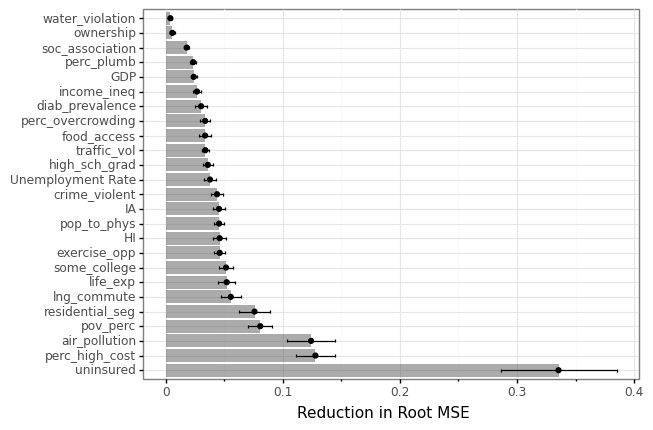

<ggplot: (8779342219734)>

In [106]:
## visualize the dataframe above using ggplot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in Root MSE",x="")
)

The five variables the model relied on the most are the number of uninsured people in a county; the percent of people with high housing costs; a measure of air pollution in a county; the level of residential segregation in a county; and the poverty rate in a county. 

Let's explore these variables further using partial dependency plots.

In [107]:
## import requred packages
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

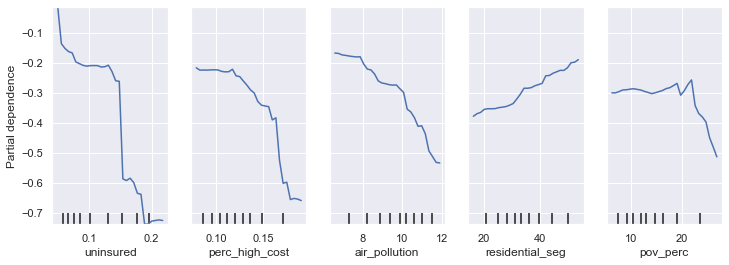

In [108]:
# Target specific features (top 5 important variables)
features = ['uninsured','perc_high_cost','air_pollution','residential_seg','pov_perc']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

Like before, almost all the important variables have a negative relationship with the outcome variable. However, there are some irregularities in the relationship. For instance, as the number of uninsured adults increases, we first see a sharp decline in disparity followed by a leveling off. And then, right after the uninsured rate reach a little over 0.1, there is a sharp decline in disparity again.  It looks like, past 0.2 on the x-axis, the disparity seems to level-off. 

Similarly, as the percent of poeple with high housing costs increases we see a sharp decline in disparity, where the the Black population in a county far exceeds the number of COVID-19 cases amonst the Black population in a county. 

Air pollution has almost a linear downward trend: as air pollution in a county increases, the disparity level decreases. Note that "average air_pollution is a measure of annual concentration of fine particulate pollution in the county. Fine particulate matter is defined as particles of air pollutants with an aerodynamic diameter less than 2.5 micrometers (PM2.5)" (See county health rankings page: https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-factors/physical-environment/air-water-quality/air-pollution-particulate-matter).


Poverty percent has an intersting distribution. We see that at poverty level of 10 and a little over 10, the disparity remains constant, a sharp increase is observed at around x=20, followed by a sharp decline in disparity. 

An intersting insight is that disparity amongst the Black population increases almost linearly with residential segregation.  However, note that the scale of the y-axis is less than zero. Although an increase is observed, according to our index, since these values fall below zero, a disparity is not detected. Nevertheless, it is interesting to see that some observation are closer to disparity than others when residential segregatio goes up. 


Let's use ICE plots to see if there are any interactions/heterogenous effects in the three out of the five most important variables

Since it is difficult to interpret ICE plots because each observation possess different baselines, the plot will be centered around the baseline (minimum) value of the variable of interest.  

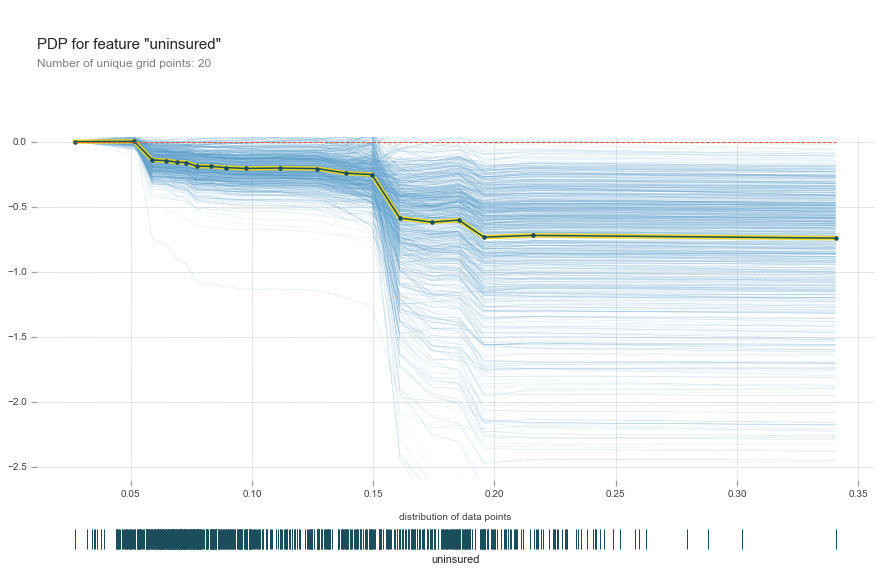

In [109]:
## PDP for feature='uninsured'
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="uninsured",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'uninsured',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

Unlike attempt three, it looks like our preprocessing steps have addressed some of the issues of heterogeneity observed, where some lines were going past the minimum and not necessarily following the same direction as the other lines shooting off from the baseline. While there seems to be a general trend of seeing lower measures of disparity as the percent of uninsured adults increases, we still see quite a few variations: for instance looking at the spread of the blue lines, it is evident that for some observations, an increase in the number of uninsured adults is associated with  disparity measures that are closer to zero (i.e, closer to a disparty being detected) while in others, a decrease is met with lower levels of disparity.

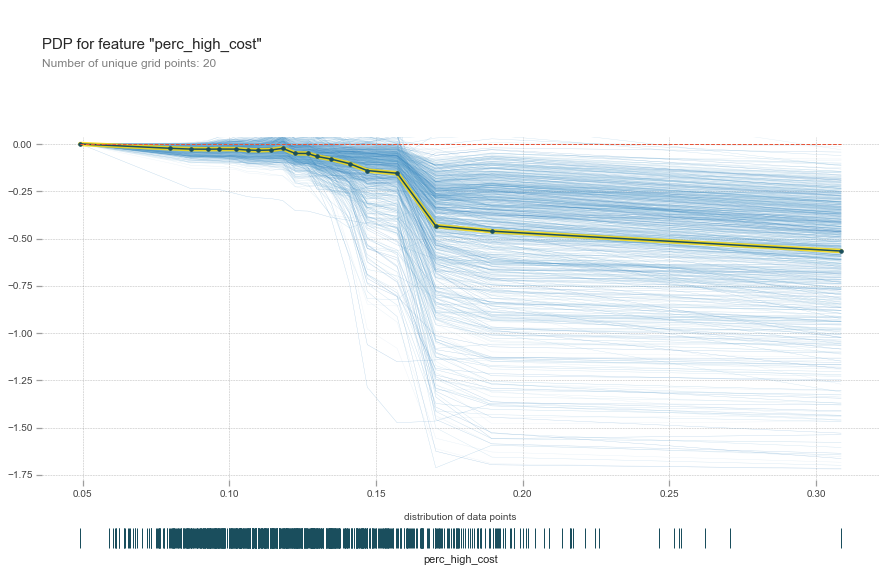

In [110]:
## PDP for feature='perc_high_cost'
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="perc_high_cost",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'perc_high_cost',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

There seems to be presence of heterogenous effects here because ther are clearly quite a few blue lines that shoot above the baseline of zero. There might be something else that is causing this variation.....

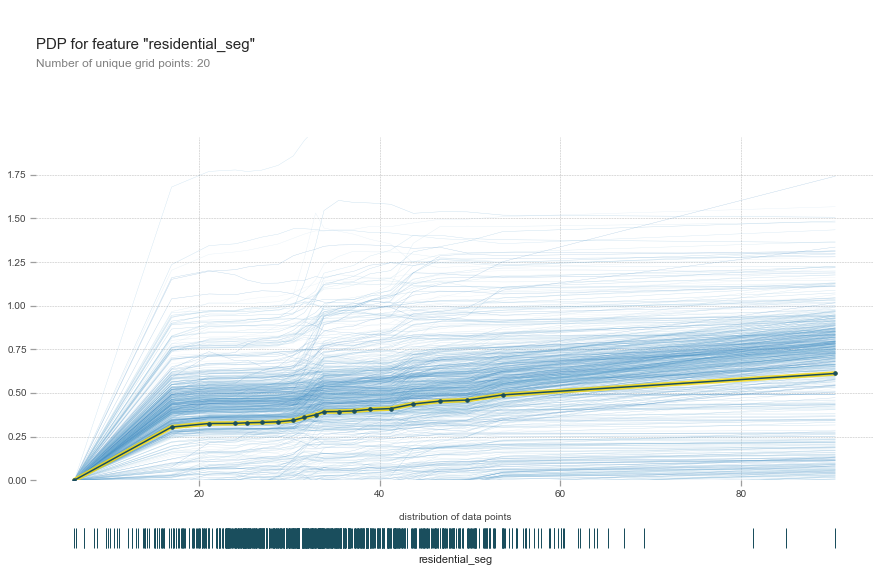

In [111]:
## PDP for feature='residential_seg'
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="residential_seg",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'residential_seg',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

### Test Performance for outcome variable `disp_index_BA`

In [113]:
## make sure test does not include any NAs
test_X.isnull().sum()

water_violation      0
IA                   0
HI                   0
GDP                  0
pov_perc             0
Unemployment Rate    0
traffic_vol          0
ownership            0
residential_seg      0
pop_to_phys          0
air_pollution        0
uninsured            0
exercise_opp         0
income_ineq          0
crime_violent        0
high_sch_grad        0
some_college         0
soc_association      0
perc_high_cost       0
perc_overcrowding    0
perc_plumb           0
lng_commute          0
life_exp             0
diab_prevalence      0
food_access          0
dtype: int64

In [114]:
## check for -inf
test_X.min()

water_violation       0.000000
IA                    2.995732
HI                    4.700480
GDP                  10.900270
pov_perc              4.900000
Unemployment Rate     0.530628
traffic_vol               -inf
ownership             1.000000
residential_seg       2.433584
pop_to_phys           6.545687
air_pollution         3.400000
uninsured             0.040723
exercise_opp          0.000000
income_ineq           3.480230
crime_violent         3.587608
high_sch_grad         0.634000
some_college          0.208518
soc_association       0.000000
perc_high_cost        0.046889
perc_overcrowding    -6.835185
perc_plumb                -inf
lng_commute           0.076000
life_exp             70.310741
diab_prevalence       0.038000
food_access           0.000840
dtype: float64

In [115]:
## check for +inf
test_X.max()

water_violation       1.000000
IA                    9.728956
HI                   12.764499
GDP                  18.938024
pov_perc             42.500000
Unemployment Rate     2.116256
traffic_vol           7.652869
ownership             2.000000
residential_seg      64.311528
pop_to_phys           9.896564
air_pollution        13.300000
uninsured             0.339399
exercise_opp          1.000000
income_ineq           8.473708
crime_violent         7.312842
high_sch_grad         0.981818
some_college          0.903366
soc_association      38.341721
perc_high_cost        0.233259
perc_overcrowding    -2.478629
perc_plumb           -2.429477
lng_commute           0.621000
life_exp             86.061144
diab_prevalence       0.310000
food_access           0.317650
dtype: float64

There are -inf values in the test data. These will be replaced with 0 because the predict function sklearn cannot deal with inf values.

In [116]:
## replace -inf values with 0
test_X=test_X.replace([-np.inf, np.nan], 0)

In [117]:
## confirm removal of -inf 
test_X.min()

water_violation       0.000000
IA                    2.995732
HI                    4.700480
GDP                  10.900270
pov_perc              4.900000
Unemployment Rate     0.530628
traffic_vol           0.000000
ownership             1.000000
residential_seg       2.433584
pop_to_phys           6.545687
air_pollution         3.400000
uninsured             0.040723
exercise_opp          0.000000
income_ineq           3.480230
crime_violent         3.587608
high_sch_grad         0.634000
some_college          0.208518
soc_association       0.000000
perc_high_cost        0.046889
perc_overcrowding    -6.835185
perc_plumb           -6.387961
lng_commute           0.076000
life_exp             70.310741
diab_prevalence       0.038000
food_access           0.000840
dtype: float64

In [118]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [119]:
m.mean_squared_error(test_y,pred_y)

1.079989255559334

In [120]:
m.r2_score(test_y,pred_y)

0.16306501668147677

In [124]:
## change from array to dataframe for visualization
pred_y=pd.DataFrame(pred_y)

In [127]:
## reset index to combine pred_y and train_y into one dataframe and visualize
train_y.reset_index(drop=True, inplace=True)

In [128]:
dat = pd.concat([pred_y, train_y], axis=1)

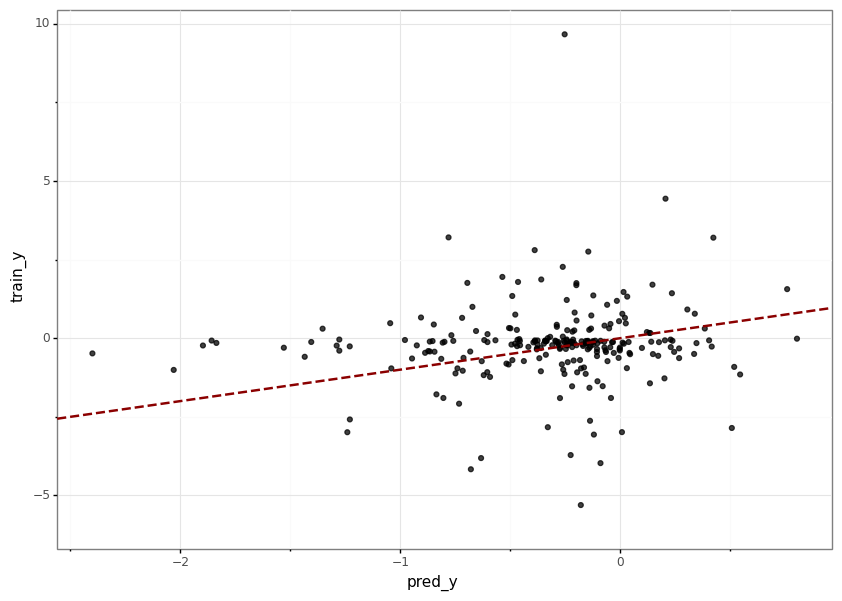

<ggplot: (8779341332200)>

In [129]:
   (
     ggplot(dat,aes(x='pred_y',y="train_y")) +
     geom_point(alpha=.75) +
      geom_abline(linetype="dashed",color="darkred",size=1) +
      theme_bw() +
       theme(figure_size=(10,7))
  )

### Re-split and Re-model data for new outcome variable 

**Outcome Variable `disp_index_HI`: Diparity index tracking COVID-19 case disparity in Hispanic Population**

Now let's resplit the pre-processed data frame and attempt the modeling process of the outcome variable 'disp_index_HI'--index tracking disparity amongst the Hispanic population in a county.

In [174]:
##isolate outcome and features
y = df2[['disp_index_HI']]
##drop irrelevant columns when isolating features from outcome (including other outcome variables)
X = df2.drop(columns=['disp_index_BA','fips','state','county','cases_bl_pop', 'cases_na_pop',
       'cases_hi_pop', 'cases_aa_pop', 'bl_pop', 'na_pop', 'hi_pop', 'aa_pop',
                     'disp_index_BA','disp_index_NA','disp_index_BA','disp_index_AA'])
## also remove black population column because it was used to create the outcome variable
X=X.drop(columns=['HI'])

### Modeling Pipeline

In [175]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['water_violation', 'IA', 'BA', 'GDP', 'pov_perc', 'Unemployment Rate',
       'traffic_vol', 'ownership', 'residential_seg', 'pop_to_phys',
       'air_pollution', 'uninsured', 'exercise_opp', 'income_ineq',
       'crime_violent', 'high_sch_grad', 'some_college', 'soc_association',
       'perc_high_cost', 'perc_overcrowding', 'perc_plumb', 'lng_commute',
       'life_exp', 'diab_prevalence', 'food_access'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[i for i in range(20)]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[5, 10, 20],
     'model__n_estimators':[100,500,1000],
     'model__max_features': [10,20,30]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_root_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['water_violation',
                                                                          'IA',
                                                                          'BA',
                                                                          'GDP',
                                                                          'pov_perc',
                                                                          'Unemployment '
                                                                          'Rate',
                                                                          'traffic_vol',
                            

In [177]:
## what is the best score
search.best_score_

-1.0549752481824382

In [178]:
## best parameter configuration
search.best_params_

{'model': RandomForestRegressor(max_depth=10, max_features=10),
 'model__max_depth': 10,
 'model__max_features': 10,
 'model__n_estimators': 100}

In [179]:
## which model performed best
search.best_estimator_

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['water_violation', 'IA',
                                                   'BA', 'GDP', 'pov_perc',
                                                   'Unemployment Rate',
                                                   'traffic_vol', 'ownership',
                                                   'residential_seg',
                                                   'pop_to_phys',
                                                   'air_pollution', 'uninsured',
                                                   'exercise_opp',
                                                   'income_ineq',
                                                   'crime_violent',
                                                   'high_sch_grad',
                                                   'some_college',
                                       